## TP Apprentissage par Renforcement avec MiniGrid

**Auteur:** SOW OUMOU - Ameto-Cornelia-ADANTO 

Ce notebook vous guide à travers l'implémentation et la comparaison de Q-Learning et DQN sur MiniGrid.

##  Installation et Imports

In [ ]:
# Installation des dépendances (décommentez si nécessaire)
# !pip install gymnasium minigrid numpy matplotlib torch tqdm

In [23]:
import gymnasium as gym
import minigrid
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from collections import defaultdict, deque
from tqdm import tqdm
import pickle
from collections import deque, namedtuple
import torch.optim as optim
import random

##  Partie 1: Exploration de MiniGrid

In [3]:
# Créer l'environnement
env = gym.make('MiniGrid-Empty-8x8-v0', render_mode='rgb_array')

print("Informations sur l'environnement:")
print(f"Espace d'observation: {env.observation_space}")
print(f"Espace d'actions: {env.action_space}")
print(f"Nombre d'actions: {env.action_space.n}")

Informations sur l'environnement:
Espace d'observation: Dict('direction': Discrete(4), 'image': Box(0, 255, (7, 7, 3), uint8), 'mission': MissionSpace(<function EmptyEnv._gen_mission at 0x00000124CF90C860>, None))
Espace d'actions: Discrete(7)
Nombre d'actions: 7


In [4]:
# Actions disponibles
actions = {
    0: "Tourner à gauche",
    1: "Tourner à droite",
    2: "Avancer",
    3: "Ramasser",
    4: "Déposer",
    5: "Basculer",
    6: "Terminer"
}

for action_id, description in actions.items():
    if action_id < env.action_space.n:
        print(f"Action {action_id}: {description}")

Action 0: Tourner à gauche
Action 1: Tourner à droite
Action 2: Avancer
Action 3: Ramasser
Action 4: Déposer
Action 5: Basculer
Action 6: Terminer


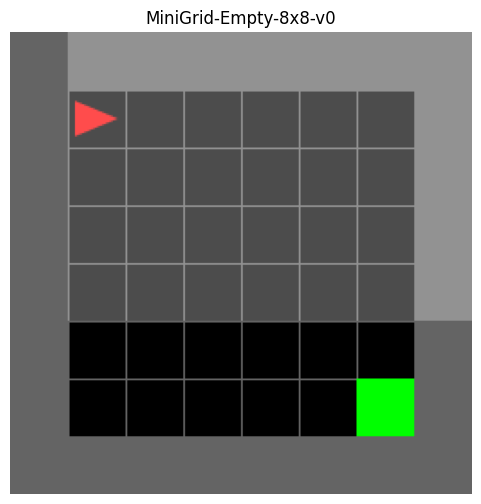


Structure de l'observation:
image: shape=(7, 7, 3)
direction: 0
mission: get to the green goal square


In [5]:
# Visualiser l'environnement
obs, info = env.reset()
img = env.render()

plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.title("MiniGrid-Empty-8x8-v0")
plt.axis('off')
plt.show()

print("\nStructure de l'observation:")
if isinstance(obs, dict):
    for key, value in obs.items():
        if isinstance(value, np.ndarray):
            print(f"{key}: shape={value.shape}")
        else:
            print(f"{key}: {value}")

In [6]:
# Test avec des actions aléatoires
env.reset()
total_reward = 0

for step in range(50):
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    total_reward += reward
    
    if terminated or truncated:
        print(f"Épisode terminé à l'étape {step+1}")
        print(f"Récompense totale: {total_reward}")
        break

env.close()

##  Partie 2: Implémentation Q-Learning

In [7]:
class QLearningAgent:
    """Agent Q-Learning simplifié pour notebook."""
    
    def __init__(self, action_space_size, learning_rate=0.1, gamma=0.99, 
                 epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.995):
        self.action_space_size = action_space_size
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.q_table = defaultdict(lambda: np.zeros(action_space_size))
        
    def state_to_key(self, obs):
        if isinstance(obs, dict) and 'image' in obs:
            return tuple(obs['image'].flatten())
        return tuple(np.array(obs).flatten())
    
    def select_action(self, state, training=True):
        if training and np.random.random() < self.epsilon:
            return np.random.randint(self.action_space_size)
        state_key = self.state_to_key(state)
        return np.argmax(self.q_table[state_key])
    
    def update(self, state, action, reward, next_state, done):
        state_key = self.state_to_key(state)
        next_state_key = self.state_to_key(next_state)
        
        current_q = self.q_table[state_key][action]
        max_next_q = 0 if done else np.max(self.q_table[next_state_key])
        new_q = current_q + self.learning_rate * (reward + self.gamma * max_next_q - current_q)
        self.q_table[state_key][action] = new_q
    
    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)

print(" Classe QLearningAgent définie")

 Classe QLearningAgent définie


In [10]:
# Entraîner l'agent Q-Learning
env = gym.make('MiniGrid-Empty-8x8-v0')
agent_qlearning = QLearningAgent(env.action_space.n)

num_episodes = 1000
rewards_qlearning = []
steps_qlearning = []

for episode in tqdm(range(num_episodes), desc="Entraînement Q-Learning"):
    state, _ = env.reset()
    episode_reward = 0
    episode_steps = 0
    
    for step in range(500):
        action = agent_qlearning.select_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        
        agent_qlearning.update(state, action, reward, next_state, done)
        
        episode_reward += reward
        episode_steps += 1
        state = next_state
        
        if done:
            break
    
    agent_qlearning.decay_epsilon()
    rewards_qlearning.append(episode_reward)
    steps_qlearning.append(episode_steps)

env.close()
print(" Entraînement Q-Learning terminé")

Entraînement Q-Learning: 100%|██████████| 1000/1000 [00:37<00:00, 26.47it/s]

 Entraînement Q-Learning terminé


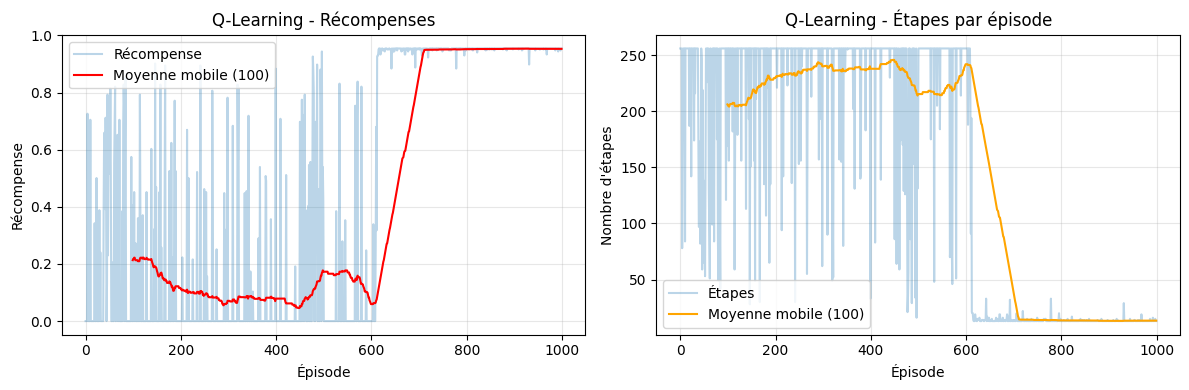

Récompense moyenne (derniers 100 ép.): 0.953
Étapes moyennes (derniers 100 ép.): 13.4


In [11]:
# Visualiser les résultats Q-Learning
window = 100
moving_avg = np.convolve(rewards_qlearning, np.ones(window)/window, mode='valid')

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(rewards_qlearning, alpha=0.3, label='Récompense')
plt.plot(range(window-1, len(rewards_qlearning)), moving_avg, 
         color='red', label=f'Moyenne mobile ({window})')
plt.xlabel('Épisode')
plt.ylabel('Récompense')
plt.title('Q-Learning - Récompenses')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
moving_avg_steps = np.convolve(steps_qlearning, np.ones(window)/window, mode='valid')
plt.plot(steps_qlearning, alpha=0.3, label='Étapes')
plt.plot(range(window-1, len(steps_qlearning)), moving_avg_steps,
         color='orange', label=f'Moyenne mobile ({window})')
plt.xlabel('Épisode')
plt.ylabel('Nombre d\'étapes')
plt.title('Q-Learning - Étapes par épisode')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Récompense moyenne (derniers 100 ép.): {np.mean(rewards_qlearning[-100:]):.3f}")
print(f"Étapes moyennes (derniers 100 ép.): {np.mean(steps_qlearning[-100:]):.1f}")

##  Partie 3: Implémentation DQN

*(Note: L'implémentation complète de DQN est dans dqn_agent.py)*

Pour utiliser DQN dans ce notebook, vous pouvez importer la classe depuis le fichier Python.

In [21]:
class DQNAgent:
    """
    Agent utilisant Deep Q-Network.
    
    Caractéristiques:
    - Réseau de neurones pour approximer Q
    - Replay buffer pour décorréler les expériences
    - Target network pour stabiliser l'apprentissage
    """
    
    def __init__(self,
                 input_size,
                 action_space_size,
                 hidden_sizes=[128, 64],
                 learning_rate=0.001,
                 gamma=0.99,
                 epsilon_start=1.0,
                 epsilon_end=0.01,
                 epsilon_decay=0.995,
                 buffer_capacity=10000,
                 batch_size=64,
                 target_update_freq=10):
        """
        Initialise l'agent DQN.
        
        Args:
            input_size: Taille de l'observation
            action_space_size: Nombre d'actions
            hidden_sizes: Architecture du réseau
            learning_rate: Taux d'apprentissage
            gamma: Facteur d'actualisation
            epsilon_start, epsilon_end, epsilon_decay: Paramètres epsilon-greedy
            buffer_capacity: Taille du replay buffer
            batch_size: Taille des mini-batches
            target_update_freq: Fréquence de mise à jour du target network
        """
        self.action_space_size = action_space_size
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.batch_size = batch_size
        self.target_update_freq = target_update_freq
        
        # Device
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Utilisation de: {self.device}")
        
        # Réseaux
        self.policy_net = DQN(input_size, action_space_size, hidden_sizes).to(self.device)
        self.target_net = DQN(input_size, action_space_size, hidden_sizes).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        
        # Optimiseur
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=learning_rate)
        self.loss_fn = nn.MSELoss()
        
        # Replay buffer
        self.replay_buffer = ReplayBuffer(buffer_capacity)
        
        # Statistiques
        self.training_rewards = []
        self.training_steps = []
        self.losses = []
        self.update_count = 0
    
    def preprocess_state(self, state):
        """
        Prétraite l'observation pour l'entrée du réseau.
        
        Args:
            state: Observation brute
            
        Returns:
            Tensor PyTorch
        """
        if isinstance(state, dict) and 'image' in state:
            state = state['image'].flatten()
        elif isinstance(state, np.ndarray):
            state = state.flatten()
        else:
            state = np.array(state).flatten()
        
        return torch.FloatTensor(state).to(self.device)
    
    def select_action(self, state, training=True):
        """
        Sélectionne une action selon epsilon-greedy.
        
        Args:
            state: État actuel
            training: Mode entraînement ou évaluation
            
        Returns:
            Action sélectionnée
        """
        if training and random.random() < self.epsilon:
            return random.randint(0, self.action_space_size - 1)
        else:
            with torch.no_grad():
                state_tensor = self.preprocess_state(state).unsqueeze(0)
                q_values = self.policy_net(state_tensor)
                return q_values.argmax(1).item()
    
    def update(self):
        """
        Effectue une mise à jour du réseau avec un batch du replay buffer.
        """
        if len(self.replay_buffer) < self.batch_size:
            return None
        
        # Échantillonner un batch
        transitions = self.replay_buffer.sample(self.batch_size)
        batch = Transition(*zip(*transitions))
        
        # Convertir en tensors
        state_batch = torch.stack([self.preprocess_state(s) for s in batch.state])
        action_batch = torch.LongTensor(batch.action).unsqueeze(1).to(self.device)
        reward_batch = torch.FloatTensor(batch.reward).to(self.device)
        next_state_batch = torch.stack([self.preprocess_state(s) for s in batch.next_state])
        done_batch = torch.FloatTensor(batch.done).to(self.device)
        
        # Q-values actuelles
        current_q_values = self.policy_net(state_batch).gather(1, action_batch).squeeze()
        
        # Q-values futures (avec target network)
        with torch.no_grad():
            next_q_values = self.target_net(next_state_batch).max(1)[0]
            target_q_values = reward_batch + (1 - done_batch) * self.gamma * next_q_values
        
        # Calculer la perte
        loss = self.loss_fn(current_q_values, target_q_values)
        
        # Optimisation
        self.optimizer.zero_grad()
        loss.backward()
        # Gradient clipping pour stabilité
        torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), 1.0)
        self.optimizer.step()
        
        self.update_count += 1
        
        # Mise à jour du target network
        if self.update_count % self.target_update_freq == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())
        
        return loss.item()
    
    def decay_epsilon(self):
        """Décroît epsilon."""
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)

    def train(self, env, num_episodes=1000, max_steps=1000, verbose=True):
        """
        Entraîne l'agent DQN.
        
        Args:
            env: Environnement Gymnasium
            num_episodes: Nombre d'épisodes
            max_steps: Étapes max par épisode
            verbose: Affichage
            
        Returns:
            Historique d'entraînement
        """
        if verbose:
            print(f"\n{'='*60}")
            print(f"ENTRAÎNEMENT DQN")
            print(f"{'='*60}")
            print(f"Device: {self.device}")
            print(f"Épisodes: {num_episodes}")
            print(f"Batch size: {self.batch_size}")
            print(f"Buffer capacity: {self.replay_buffer.buffer.maxlen}")
            print(f"{'='*60}\n")
        
        episode_iterator = tqdm(range(num_episodes)) if verbose else range(num_episodes)
        
        for episode in episode_iterator:
            state, info = env.reset()
            episode_reward = 0
            episode_steps = 0
            episode_losses = []
            
            for step in range(max_steps):
                # Sélectionner et exécuter action
                action = self.select_action(state, training=True)
                next_state, reward, terminated, truncated, info = env.step(action)
                done = terminated or truncated
                
                # Stocker dans le buffer
                self.replay_buffer.push(state, action, reward, next_state, done)
                
                # Mise à jour du réseau
                loss = self.update()
                if loss is not None:
                    episode_losses.append(loss)
                
                episode_reward += reward
                episode_steps += 1
                state = next_state
                
                if done:
                    break
            
            # Décroissance epsilon
            self.decay_epsilon()
            
            # Statistiques
            self.training_rewards.append(episode_reward)
            self.training_steps.append(episode_steps)
            if episode_losses:
                self.losses.append(np.mean(episode_losses))
            
            # Affichage périodique
            if verbose and (episode + 1) % 100 == 0:
                avg_reward = np.mean(self.training_rewards[-100:])
                avg_steps = np.mean(self.training_steps[-100:])
                avg_loss = np.mean(self.losses[-100:]) if self.losses else 0
                tqdm.write(f"Épisode {episode+1}/{num_episodes} | "
                          f"Récompense: {avg_reward:.3f} | "
                          f"Étapes: {avg_steps:.1f} | "
                          f"Loss: {avg_loss:.4f} | "
                          f"Epsilon: {self.epsilon:.3f} | "
                          f"Buffer: {len(self.replay_buffer)}")
        
        return {
            'rewards': self.training_rewards,
            'steps': self.training_steps,
            'losses': self.losses
        }

In [24]:
# Créer l'environnement
env = gym.make('MiniGrid-Empty-8x8-v0')

# Obtenir la taille de l'observation
obs, _ = env.reset()
if isinstance(obs, dict) and 'image' in obs:
    input_size = obs['image'].flatten().shape[0]
else:
    input_size = np.array(obs).flatten().shape[0]

print(f"Taille observation: {input_size}")

# Créer l'agent DQN
agent_dqn = DQNAgent(
    input_size=input_size,
    action_space_size=env.action_space.n
)

# Entraîner
history_dqn = agent_dqn.train(env, num_episodes=500, max_steps=500)
env.close()

Taille observation: 147
Utilisation de: cpu

ENTRAÎNEMENT DQN
Device: cpu
Épisodes: 500
Batch size: 64
Buffer capacity: 10000



 20%|██        | 100/500 [04:05<16:15,  2.44s/it]

Épisode 100/500 | Récompense: 0.100 | Étapes: 234.7 | Loss: 1.2449 | Epsilon: 0.606 | Buffer: 10000


 40%|████      | 200/500 [07:00<09:03,  1.81s/it]

Épisode 200/500 | Récompense: 0.370 | Étapes: 170.3 | Loss: 0.0252 | Epsilon: 0.367 | Buffer: 10000


 60%|██████    | 300/500 [10:42<03:33,  1.07s/it]

Épisode 300/500 | Récompense: 0.194 | Étapes: 213.5 | Loss: 0.0054 | Epsilon: 0.222 | Buffer: 10000


 80%|████████  | 400/500 [12:53<02:08,  1.29s/it]

Épisode 400/500 | Récompense: 0.295 | Étapes: 187.6 | Loss: 0.0013 | Epsilon: 0.135 | Buffer: 10000


100%|██████████| 500/500 [14:36<00:00,  1.75s/it]

Épisode 500/500 | Récompense: 0.581 | Étapes: 114.0 | Loss: 0.0011 | Epsilon: 0.082 | Buffer: 10000


In [26]:
def evaluate(self, env, num_episodes=100, max_steps=1000):
        """
        Évalue l'agent.
        
        Args:
            env: Environnement
            num_episodes: Nombre d'épisodes
            max_steps: Étapes max
            
        Returns:
            Statistiques d'évaluation
        """
        rewards = []
        steps = []
        successes = 0
        
        self.policy_net.eval()
        
        for episode in range(num_episodes):
            state, info = env.reset()
            episode_reward = 0
            episode_steps = 0
            
            for step in range(max_steps):
                action = self.select_action(state, training=False)
                state, reward, terminated, truncated, info = env.step(action)
                
                episode_reward += reward
                episode_steps += 1
                
                if terminated or truncated:
                    if reward > 0:
                        successes += 1
                    break
            
            rewards.append(episode_reward)
            steps.append(episode_steps)
        
        self.policy_net.train()
        
        return {
            'mean_reward': np.mean(rewards),
            'std_reward': np.std(rewards),
            'mean_steps': np.mean(steps),
            'std_steps': np.std(steps),
            'success_rate': successes / num_episodes,
            'rewards': rewards,
            'steps': steps
        }

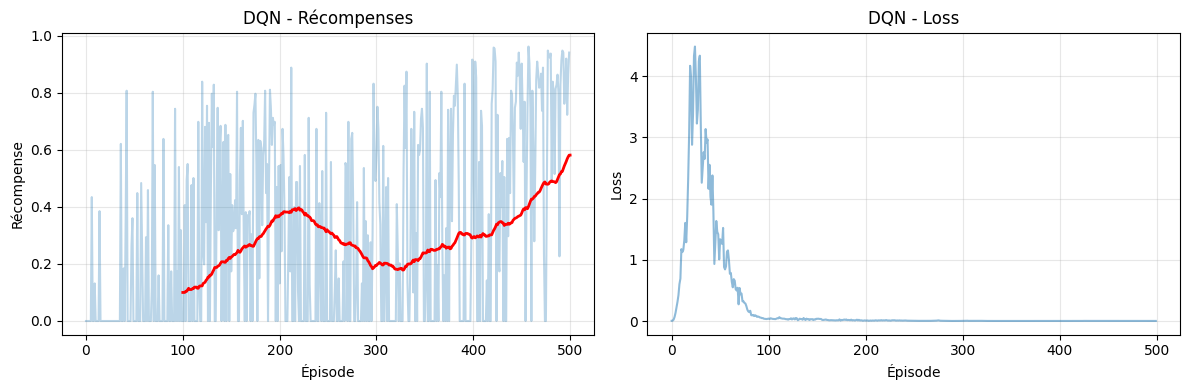

In [28]:
# Visualiser
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
window = 100
moving_avg = np.convolve(history_dqn['rewards'], np.ones(window)/window, mode='valid')
plt.plot(history_dqn['rewards'], alpha=0.3)
plt.plot(range(window, len(history_dqn['rewards'])+1), moving_avg, 'r-', linewidth=2)
plt.xlabel('Épisode')
plt.ylabel('Récompense')
plt.title('DQN - Récompenses')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
if history_dqn['losses']:
    plt.plot(history_dqn['losses'], alpha=0.5)
    plt.xlabel('Épisode')
    plt.ylabel('Loss')
    plt.title('DQN - Loss')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Partie 4: Évaluation

In [29]:
# Évaluer Q-Learning
env = gym.make('MiniGrid-Empty-8x8-v0')
eval_rewards = []
eval_steps = []
successes = 0

for episode in range(100):
    state, _ = env.reset()
    episode_reward = 0
    episode_steps = 0
    
    for step in range(500):
        action = agent_qlearning.select_action(state, training=False)
        state, reward, terminated, truncated, _ = env.step(action)
        
        episode_reward += reward
        episode_steps += 1
        
        if terminated or truncated:
            if reward > 0:
                successes += 1
            break
    
    eval_rewards.append(episode_reward)
    eval_steps.append(episode_steps)

env.close()

print("\n=== RÉSULTATS D'ÉVALUATION Q-LEARNING ===")
print(f"Récompense moyenne: {np.mean(eval_rewards):.3f} ± {np.std(eval_rewards):.3f}")
print(f"Étapes moyennes: {np.mean(eval_steps):.1f} ± {np.std(eval_steps):.1f}")
print(f"Taux de succès: {successes}%")


=== RÉSULTATS D'ÉVALUATION Q-LEARNING ===
Récompense moyenne: 0.954 ± 0.000
Étapes moyennes: 13.0 ± 0.0
Taux de succès: 100%


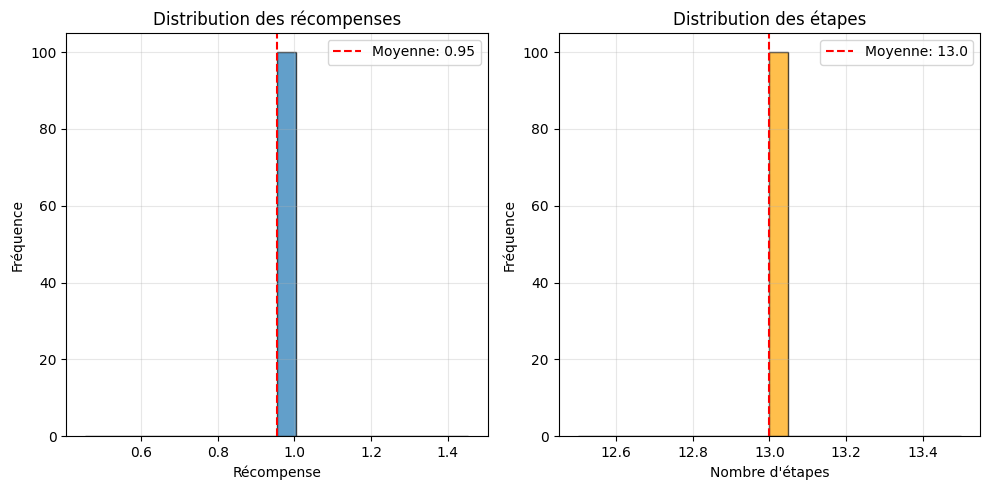

In [30]:
# Distribution des récompenses
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.hist(eval_rewards, bins=20, edgecolor='black', alpha=0.7)
plt.axvline(np.mean(eval_rewards), color='red', linestyle='--', 
            label=f'Moyenne: {np.mean(eval_rewards):.2f}')
plt.xlabel('Récompense')
plt.ylabel('Fréquence')
plt.title('Distribution des récompenses')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(eval_steps, bins=20, edgecolor='black', alpha=0.7, color='orange')
plt.axvline(np.mean(eval_steps), color='red', linestyle='--',
            label=f'Moyenne: {np.mean(eval_steps):.1f}')
plt.xlabel('Nombre d\'étapes')
plt.ylabel('Fréquence')
plt.title('Distribution des étapes')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

##  Sauvegarde des résultats

In [32]:
# Sauvegarder l'agent
with open('qlearning_agent.pkl', 'wb') as f:
    pickle.dump({
        'q_table': dict(agent_qlearning.q_table),
        'training_rewards': rewards_qlearning,
        'training_steps': steps_qlearning,
        'eval_rewards': eval_rewards,
        'eval_steps': eval_steps
    }, f)

print(" Agent sauvegardé dans 'qlearning_agent.pkl'")

 Agent sauvegardé dans 'qlearning_agent.pkl'


##  Conclusions

### À compléter:

1. **Performance observée:**
   - Taux de succès: ____%
   - Récompense moyenne: ____
   - Convergence après ____ épisodes

2. **Analyse:**
   - Points forts de Q-Learning:
   - Limitations observées:
   - Comparaison avec DQN:

3. **Améliorations possibles:**
   - 
   - 
   - 